In [1]:
'''import subprocess

url = "https://www.kaggle.com/api/v1/datasets/download/lexset/synthetic-asl-alphabet"
output_path = "./archive.zip"

subprocess.run(["curl", "-L", "-o", output_path, url])

!unzip ./archive.zip -d ./dataset '''


# !mv ./dataset/Train_Alphabet /lustre/isaac/scratch/jdosch1/dataset_COSC307
# !mv ./dataset/Test_Alphabet /lustre/isaac/scratch/jdosch1/dataset_COSC307


'import subprocess\n\nurl = "https://www.kaggle.com/api/v1/datasets/download/lexset/synthetic-asl-alphabet"\noutput_path = "./archive.zip"\n\nsubprocess.run(["curl", "-L", "-o", output_path, url])\n\n!unzip ./archive.zip -d ./dataset '

In [1]:
# Mounting dataset from Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# Libraries for data storage and image processing
'''!python --version
!pip install numpy
!pip install pandas
!pip install pillow
!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install opencv-python '''

import numpy as np
import pandas as pd
import os, re
from PIL import Image, ImageEnhance

# TensorFlow/Keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # Forces TensorFlow functions to execute eagerly
print("Eager Execution:", tf.executing_eagerly())


from tensorflow import keras
import tensorflow_hub as hub

from keras.layers import Dense, Input
from keras.models import Sequential
from keras import metrics, models, layers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import canny


# SKLearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

2024-11-28 16:19:52.896282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 16:19:52.911240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732828792.927386  595123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732828792.932481  595123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:19:52.948981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Eager Execution: True


Now we read in the data from the local directory where it is stored, and process the images.

In [2]:
# We will define the paths to our files
# Current directory structure: train has subdirectories A-Z, each with images stored inside,
# test just has the files with the letter, label is in file name.
# train_images = '../dataset/asl_alphabet_train/asl_alphabet_train'
# test_images = '../dataset/asl_alphabet_test/asl_alphabet_test'
# train_images = '/content/drive/My Drive/dataset/asl_alphabet_train/asl_alphabet_train'
# test_images = '/content/drive/My Drive/dataset/asl_alphabet_test/asl_alphabet_test'

train_images = '/lustre/isaac/scratch/jdosch1/dataset_COSC307/asl_alphabet_train/asl_alphabet_train'
test_images = '/lustre/isaac/scratch/jdosch1/dataset_COSC307/asl_alphabet_test/asl_alphabet_test'

In [3]:
!nvidia-smi

Thu Nov 28 16:19:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:1A:00.0 Off |                    0 |
| N/A   45C    P8             15W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load Data #

Read in the data from the local directory and store it in a pandas DataFrame. We will display the first 5 rows with df.head() to validate our result.

In [4]:
train_data = pd.DataFrame()
categories = []
data = []
exclude_columns = {'del', 'asl_alphabet_train', 'nothing', 'space', 'J', 'Z'}
include_columns = {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'}
# For dataset 2
# exclude_columns = {'Blank', 'Train_Alphabet', '.ipynb_checkpoints'}

# For dataset restriction
# include_columns = ['P', 'Y', 'R', 'O', 'V']

for subdir, dirs, files in os.walk(train_images, topdown=True):
    directory_name = os.path.basename(subdir)
    # Don't include the directory we are currently in, trying to get letter categories.
    if(directory_name in include_columns):
        # categories.append(os.path.basename(subdir).split("\\")[0])
        categories.append(directory_name)
        directory_data = []
        for file in files:
          directory_data.append(file)

        data.append(directory_data)

sorted_categories_indices = sorted(range(len(categories)), key=lambda i: categories[i])
categories = [categories[i] for i in sorted_categories_indices]
data = [data[i] for i in sorted_categories_indices]

data = [directory for directory in data if directory] # Remove null elements
df = pd.DataFrame(data, categories)

print(df)

        0          1          2          3          4          5     \
A  A1026.jpg  A2885.jpg  A1474.jpg  A1798.jpg  A1602.jpg   A823.jpg   
B  B2831.jpg  B1287.jpg  B1674.jpg   B192.jpg    B74.jpg  B1813.jpg   
C  C2192.jpg   C614.jpg  C2587.jpg  C2219.jpg  C2230.jpg  C2010.jpg   
D   D720.jpg  D1895.jpg   D424.jpg   D104.jpg  D2829.jpg  D1618.jpg   
E   E537.jpg  E1038.jpg   E166.jpg  E1566.jpg  E2604.jpg   E303.jpg   
F  F1245.jpg  F1024.jpg   F743.jpg  F2073.jpg  F2123.jpg  F2330.jpg   
G  G2208.jpg  G1240.jpg  G2429.jpg  G1059.jpg  G2930.jpg  G2500.jpg   
H  H1639.jpg   H992.jpg    H28.jpg    H69.jpg  H2614.jpg  H2747.jpg   
I  I2011.jpg   I613.jpg   I658.jpg   I296.jpg  I1667.jpg  I1927.jpg   
K  K1797.jpg  K2338.jpg  K1821.jpg   K616.jpg   K565.jpg   K381.jpg   
L   L756.jpg  L2906.jpg  L1500.jpg  L1837.jpg   L982.jpg  L1625.jpg   
M  M1085.jpg  M1288.jpg   M346.jpg   M138.jpg  M2398.jpg  M1388.jpg   
N   N368.jpg  N1110.jpg  N2496.jpg     N2.jpg  N2961.jpg   N724.jpg   
O  O28

Some information about our dataset

In [5]:
print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size}")
print(f"Data type: {df.dtypes}")
print(f"Dataset columns: {df.columns}")

Dataset shape: (24, 3000)
Dataset size: 72000
Data type: 0       object
1       object
2       object
3       object
4       object
         ...  
2995    object
2996    object
2997    object
2998    object
2999    object
Length: 3000, dtype: object
Dataset columns: RangeIndex(start=0, stop=3000, step=1)


#### Preprocess data if necessary (i.e. drop certain columns we are not using). Since pandas DataFrames do not support images, we will read the data into a numpy array. Since the dataset is considerably large, we will use a Keras function to support batching ####

In [6]:
'''train_images_list = []
for index, row in df.iterrows():
    train_images_dir = f"{train_images}/{index}"
    check = True
    for value in row:
        image_path = f"{train_images_dir}/{value}"
        img = image.load_img(image_path, target_size=(200, 200))
        img = image.img_to_array(img)
        train_images_list.append(img)

training_images = np.array(train_images_list)'''
directory = train_images
training_images, validation_images = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=include_columns,
    color_mode="grayscale",
    batch_size=128,
    image_size=(128, 128),
    seed=42,
    shuffle=True,
    validation_split=0.2,
    subset='both', # we will use 20% data for validation
)

class_names = training_images.class_names
print("Class names: ", class_names)

# !pip install tqdm

from tqdm.auto import tqdm

# Standardize dataset
means = []
stds = []

for images, _ in tqdm(training_images.unbatch()):
    images = images.numpy()
    images = images.flatten()
    # print("Images size: ", images.shape)
    means.append(images.mean())
    stds.append(images.std())

means = np.mean(means)
stds = np.std(stds)
print("Mean: ", means)
print("std: ", stds)

# Check current datatype
for images, _ in training_images.take(1): 
    print(type(images[0]))
    
# Normalize dataset to lead to faster convergence of the model - https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3
# training_images = training_images.map(process)
# validation_images = validation_images.map(process)

Found 72000 files belonging to 24 classes.
Using 57600 files for training.
Using 14400 files for validation.
Class names:  {'S', 'V', 'H', 'Q', 'N', 'D', 'A', 'F', 'X', 'C', 'O', 'B', 'P', 'U', 'M', 'W', 'I', 'E', 'K', 'L', 'T', 'R', 'G', 'Y'}


W0000 00:00:1732828810.509050  595123 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/nfs/home/jdosch1/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/nfs/home/jdosch1/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager e

0it [00:00, ?it/s]

Mean:  128.47665
std:  15.820431
<class 'tensorflow.python.framework.ops.EagerTensor'>


2024-11-28 16:20:32.179627: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-28 16:20:32.223752: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
def cannyProcess(image, label):
    def process_with_canny(image_np):
        # Ensure the input tensor has the correct shape: (batch_size, height, width, 1)
        # print(f"Input Image Shape: {image_np.shape}")  # Debugging: print input shape
        
        # If image is a batch (with 1 channel), we can remove the last dimension and process each image
        if image_np.shape[-1] == 1:  # Ensure it's grayscale
            image_np = tf.squeeze(image_np, axis=-1)  # Remove the channel dimension (128, 128, 1) -> (128, 128)
        
        # Now image_np is a 2D tensor (128, 128) per image. If it's a batch, it's (batch_size, 128, 128)
        # Let's process each image in the batch
        processed_images = []
        for img in image_np:
            # Ensure each image is a NumPy array of type float32
            img_array = np.array(img, dtype=np.float32)
            # print(f"Image Shape for Processing: {img_array.shape}")  # Debugging: print the image shape

            # Apply Canny edge detection
            detector = canny.cannyEdgeDetector([img_array], sigma=1.4, kernel_size=5, 
                                         lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)
            imgs_final = detector.detect()

            # Append the processed image (edge-detected image) to the list
            processed_images.append(imgs_final[0])  # Assuming imgs_final is a list of processed images
        
        # Convert list of processed images back to a numpy array
        processed_images_np = np.array(processed_images)

        return processed_images_np

    # Use tf.py_function to execute the processing in eager mode
    image = tf.py_function(
        process_with_canny,  # The function to execute
        [image],             # The input to the function (image tensor)
        tf.float32           # The return type of the function (processed image)
    )

    # Set the output shape (assuming it's a batch of grayscale images of shape (batch_size, 128, 128))
    image.set_shape([image.shape[0], 128, 128])  # Set the shape as a batch of 128x128 grayscale images

    return image, label


In [8]:
print(training_images)

'''
def process(image, label): # for normalizing dataset
    image = tf.cast(image/255.0, tf.float32)
    return image, label '''

brightness_layer = tf.keras.layers.RandomBrightness(factor=(0.0, 0.3)) # factor is the range for adjustment
contrast_layer = tf.keras.layers.RandomContrast(factor=(0.6)) # factor determines contrast adjustment range
gaussian_noise_layer = tf.keras.layers.GaussianNoise(stddev=0.35)
rotation_layer = tf.keras.layers.RandomRotation(factor=(-1/36, 1/36), fill_mode='reflect')
translation_layer = tf.keras.layers.RandomTranslation(height_factor=(-0.20, 0.20), width_factor=(-0.20, 0.20), fill_mode='reflect')
zoom_layer = tf.keras.layers.RandomZoom(height_factor=(-0.10, 0.10), width_factor=(-0.10, 0.10), fill_mode='reflect', interpolation='bilinear')

# Gaussian noise already applied in the model, contrast and brightness could interfere with edge detection
augmentation = tf.keras.Sequential([
    # brightness_layer,
    # contrast_layer,
    # gaussian_noise_layer,
    rotation_layer,
    translation_layer, 
    zoom_layer
]) 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


2024-11-28 16:20:52.301159: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


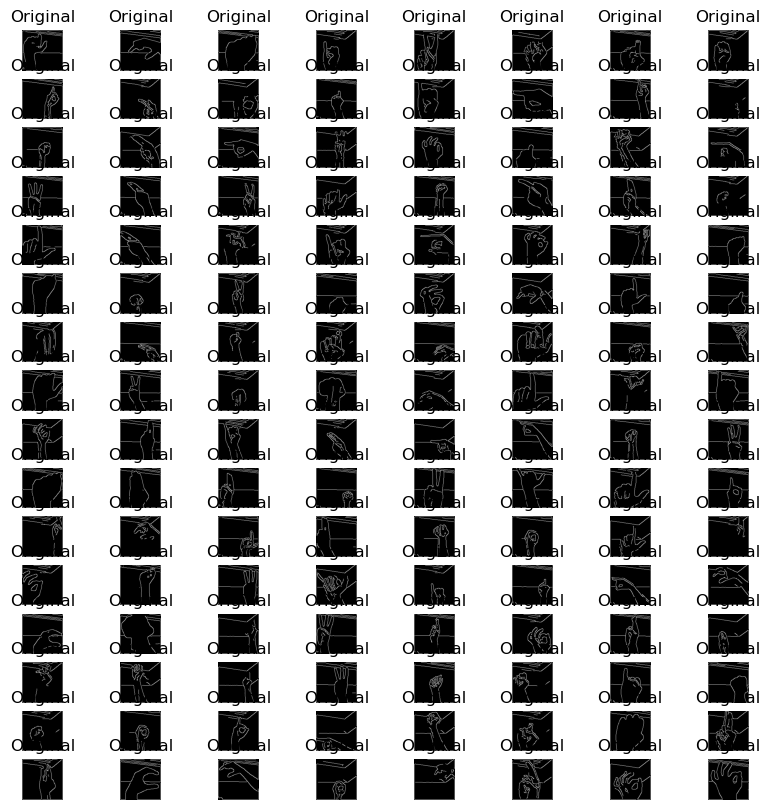

In [9]:
# Convert training images to appear to be RGB so Inception can properly classify them
# training_images = training_images.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
# validation_images = validation_images.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
def augmentation_process(image, label):
    image = augmentation(image)
    return image, label

training_images_aug = training_images.map(lambda x, y: (augmentation(x, training=True), y))
# Normalize dataset to lead to faster convergence of the model - https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3
# training_images = training_images.map(process)
# validation_images = validation_images.map(process)

def np_process(image, label):
    def numpy_processing(image):
        # Ensure the input is converted to NumPy for any NumPy-specific operations
        image = image.numpy()  
        return image

    image = tf.py_function(numpy_processing, [image], tf.float32)
    return image, label
    
# Standardization
def standardize(image, label):
    image = (image - means) / stds
    return image, label

training_images_aug = training_images_aug.map(standardize)
validation_images = validation_images.map(standardize)

training_images_aug = training_images_aug.map(np_process)

# Check current datatype
for images, _ in training_images_aug.take(1): 
    print(type(images[0]))
    
training_images_aug = training_images.map(cannyProcess)
validation_images = validation_images.map(cannyProcess)

# Check dtype again
for images, _ in training_images_aug.take(1): 
    print(type(images[0]))
    
for images, _ in training_images_aug.take(1):  # Take a single batch
    # print("Labels: ", _.numpy())

    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        # Display augmented images
        ax = plt.subplot(16, 16, i * 2 + 1)
        plt.imshow(images[i].numpy(), cmap='gray')
        plt.title("Original")
        plt.axis("off")


    plt.show() 

### Define the model: we will use a sequential model, with a relu activation function and MaxPooling 2D layers, to extract the image features, then  ###

Conv2D documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
    We will use the default kernel initializer and no bias for now, but can change later for optimization.
MaxPooling2D documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
    

In [10]:
# Mimicking the VGG16 architecture with grayscale inputs
model = models.Sequential()
model.add(Input(shape=(128, 128, 1)))


# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

# model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
'''
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
'''
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))


model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
#model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

# Using softmax because of this article, could change later: https://emeritus.org/blog/cnn-neural-network/#:~:text=The%20Fully%20Connected%20Layer:%20Making,applications%20such%20as%20image%20recognition.
model.add(layers.Dense(24, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,945,560 (156.19 MB)

 Trainable params: 40,945,560 (156.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
# We will use the Adam optimizer, for the performance reasons discussed in the following link: https://www.geeksforgeeks.org/adam-optimizer/
# Can potentially use other loss functions later for performance boost, this one chosen because
# of how the labels are meant to be classified (one-hot encoded 1-29)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min') # could use restore_best_weights, reference: https://keras.io/api/callbacks/early_stopping/
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.load_weights('VGGweights.11_24_02.weights.h5')

# In case we want to try a different optimizer, Adam can lead to overfitting
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])

# Set save of model weights callback
save_callback = tf.keras.callbacks.ModelCheckpoint(
   filepath = "./VGGweights.11_27.weights.h5", verbose=1, save_weights_only=True,
   # Save weights every 10 epochs
   save_freq='epoch')

# Set learning rate scheduler to prevent stagnation during training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Set custom early stop function
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# Reference for custom callback: https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
custom_callback = MyThresholdCallback(threshold=0.97)
EPOCHS = 1000 # Can modify later
# Fit the model to training data

history = model.fit(x=training_images_aug, validation_data=validation_images, epochs=EPOCHS, batch_size = 128, callbacks=[custom_callback, lr_scheduler])


Epoch 1/1000
450/450 ━━━━━━━━━━━━━━━━━━━━ 10387s 23s/step - accuracy: 0.0551 - loss: 3.4578 - val_accuracy: 0.2515 - val_loss: 2.9044 - learning_rate: 1.0000e-04
Epoch 2/1000
450/450 ━━━━━━━━━━━━━━━━━━━━ 10399s 23s/step - accuracy: 0.1728 - loss: 2.8281 - val_accuracy: 0.5978 - val_loss: 1.7604 - learning_rate: 1.0000e-04
Epoch 3/1000
450/450 ━━━━━━━━━━━━━━━━━━━━ 10322s 23s/step - accuracy: 0.4218 - loss: 1.8916 - val_accuracy: 0.8060 - val_loss: 0.8605 - learning_rate: 1.0000e-04
Epoch 4/1000
450/450 ━━━━━━━━━━━━━━━━━━━━ 10344s 23s/step - accuracy: 0.6265 - loss: 1.1770 - val_accuracy: 0.8827 - val_loss: 0.4904 - learning_rate: 1.0000e-04
Epoch 5/1000
450/450 ━━━━━━━━━━━━━━━━━━━━ 10364s 23s/step - accuracy: 0.7424 - loss: 0.8025 - val_accuracy: 0.9290 - val_loss: 0.3062 - learning_rate: 1.0000e-04
Epoch 6/1000
450/450 ━━━━━━━━━━━━━━━━━━━━ 10321s 23s/step - accuracy: 0.8077 - loss: 0.5844 - val_accuracy: 0.9530 - val_loss: 0.2045 - learning_rate: 1.0000e-04
Epoch 7/1000
450/450 ━━━━━━━

In [ ]:
'''
# Trying new model architecture - try and fine-tune InceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- predict all 26 classes
predictions = Dense(26, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(x=training_images_aug, validation_data=validation_images, epochs=3, batch_size = 64)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = model.fit(x=training_images_aug, validation_data=validation_images, epochs=EPOCHS, batch_size = 64, callbacks=[custom_callback, save_callback])
print("keys: ", history.history.keys())
'''

In [ ]:
''' InceptionV3 stalled at around 30% accuracy, may try learning rate scheduling if mimic VGG16 does not work.
# Load InceptionV3 in case of session timeout on Isaac
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- predict all 26 classes
predictions = Dense(26, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('weights.57.weights.h5')

history = model.fit(x=training_images_aug, validation_data=validation_images, epochs=EPOCHS, batch_size = 64, callbacks=[custom_callback, save_callback])
print("keys: ", history.history.keys()) '''

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('./COSC307_canny_edge.keras')
'''# Save model parameters after each step
!mkdir -p /content/drive/MyDrive/models

model.save('/content/drive/MyDrive/models/COSC307_Final_CNN2.keras') # tf save format works better across configurations (the model was training in a multi-GPU environment)'''